# How do the XGBoost Most Important Features perform with different comorbidities?

In [87]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import shap

from matplotlib import pyplot as plt

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/hospitalization_data.csv', dtype={'FIPS': object})
data.head()

,FIPS,Hospitalizations,Cases,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Hospitalization Rate,Case Rate,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,12041,80,1588,Florida,Gilchrist,8968.375038,21.126757,4.763684,4.847069,7.669173,...,9.381368,3.4,52.053416,7.608085,52.605415,13.496566,438.2,8698.5,0,1521
1,12107,566,6374,Florida,Putnam,12710.036010,24.952601,5.359802,4.937745,10.439560,...,7.827534,4.3,55.123245,10.481016,52.040792,10.449204,763.2,8594.6,1,1766
2,12123,97,2710,Florida,Taylor,10593.946360,23.831961,4.855759,4.745002,9.772588,...,5.633540,3.6,54.561016,9.412498,60.553383,6.022409,448.6,12533.0,1,1201
3,12091,729,20298,Florida,Okaloosa,8033.687940,15.266246,3.889858,3.875538,7.872828,...,19.608361,2.7,40.581558,17.700785,39.062417,11.659616,351.7,9793.1,0,836
4,12013,59,1686,Florida,Calhoun,10649.098250,24.278851,4.887984,4.772105,8.024691,...,7.022045,4.1,58.913803,8.432470,56.585692,11.858775,404.5,11558.2,0,1621


In [3]:
X = data.drop(["FIPS", "Hospitalizations", "Cases", "Hospitalization Rate", "State", "County"], axis=1)
y = pd.DataFrame(data["Hospitalization Rate"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
len(X.columns)

97

## MLP: XGBoost Most Important Features - '% Diagnosed Diabetes' + 'Hypertension Death Rate'

In [15]:
X_train_co = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'Hypertension Death Rate'])

X_val_co = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'Hypertension Death Rate'])

X_test_co = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'Hypertension Death Rate'])

In [16]:
"""
Loading custom dataset into Tensors
https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
"""
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.tensor(X.values).float()
        if not torch.is_tensor(y):
            self.y = torch.tensor(y.values).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_data_co = PrepareData(X_train_co, y_train)
val_data_co = PrepareData(X_val_co, y_val)
test_data_co = PrepareData(X_test_co, y_test)

In [18]:
batch_size = 8

In [19]:
train_loader_co = DataLoader(train_data_co, 
                          batch_size)

valid_loader_co = DataLoader(val_data_co, 
                          batch_size)

test_loader_co = DataLoader(test_data_co, 
                         batch_size)

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim=7, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Input
        -----
        x: tensor (batch size x important variable size)
        
        Output
        ------
        predicted values of Hosp rate
            tensor(batch size x 1)
        """
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

In [51]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [52]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_co:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_co:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_co.model')

Epoch: 1 	Training Loss: 300.402107 	Validation Loss: 256.319602
Epoch: 2 	Training Loss: 293.176384 	Validation Loss: 251.962701
Epoch: 3 	Training Loss: 307.280016 	Validation Loss: 256.590211
Epoch: 4 	Training Loss: 298.065982 	Validation Loss: 259.654455
Epoch: 5 	Training Loss: 292.558614 	Validation Loss: 251.496870
Epoch: 6 	Training Loss: 300.364503 	Validation Loss: 253.850111
Epoch: 7 	Training Loss: 296.431335 	Validation Loss: 255.566641
Epoch: 8 	Training Loss: 298.677134 	Validation Loss: 253.962404
Epoch: 9 	Training Loss: 296.411235 	Validation Loss: 254.418604
Epoch: 10 	Training Loss: 280.421896 	Validation Loss: 247.746992
Epoch: 11 	Training Loss: 289.508641 	Validation Loss: 258.726379
Epoch: 12 	Training Loss: 279.828324 	Validation Loss: 256.664433
Epoch: 13 	Training Loss: 282.607677 	Validation Loss: 252.303221
Epoch: 14 	Training Loss: 285.296181 	Validation Loss: 253.580834
Epoch: 15 	Training Loss: 284.460344 	Validation Loss: 251.574567
Epoch: 16 	Training

In [53]:
best_val_loss

190.9886738170277

In [60]:
mlp.load_state_dict(torch.load('mlp_co.model'))

In [62]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_co:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_co)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 193.611924



### Explain output through SHAP

In [54]:
mlp = MLP(input_dim=7)
mlp.load_state_dict(torch.load('mlp_co.model'))

In [55]:
x_co, _ = next(iter(train_loader_co))

In [56]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_co)

shap_values = explainer_shap.shap_values(X=x_co,
                                      ranked_outputs=True)

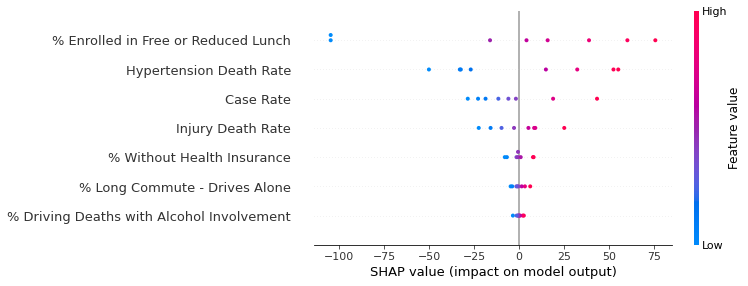

In [59]:
shap.summary_plot(shap_values, x_co, feature_names=X_train_co.columns)

## MLP: XGBoost Most Important Features - '% Diagnosed Diabetes' + 'Heart Disease Death Rate'

In [63]:
X_train_co2 = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'Heart Disease Death Rate'])

X_val_co2 = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'Heart Disease Death Rate'])

X_test_co2 = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'Heart Disease Death Rate'])

In [64]:
train_data_co2 = PrepareData(X_train_co2, y_train)
val_data_co2 = PrepareData(X_val_co2, y_val)
test_data_co2 = PrepareData(X_test_co2, y_test)

In [65]:
train_loader_co2 = DataLoader(train_data_co2, 
                          batch_size)

valid_loader_co2 = DataLoader(val_data_co2, 
                          batch_size)

test_loader_co2 = DataLoader(test_data_co2, 
                         batch_size)

In [77]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [78]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_co2:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_co2:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_co2.model')

Epoch: 1 	Training Loss: 722.185277 	Validation Loss: 649.637806
Epoch: 2 	Training Loss: 587.095339 	Validation Loss: 556.825462
Epoch: 3 	Training Loss: 523.305200 	Validation Loss: 500.096216
Epoch: 4 	Training Loss: 454.221712 	Validation Loss: 391.569999
Epoch: 5 	Training Loss: 333.116810 	Validation Loss: 253.143831
Epoch: 6 	Training Loss: 309.687597 	Validation Loss: 256.519214
Epoch: 7 	Training Loss: 296.067567 	Validation Loss: 255.363570
Epoch: 8 	Training Loss: 317.063381 	Validation Loss: 258.897910
Epoch: 9 	Training Loss: 310.297002 	Validation Loss: 253.993652
Epoch: 10 	Training Loss: 311.412793 	Validation Loss: 253.382721
Epoch: 11 	Training Loss: 305.039962 	Validation Loss: 254.591980
Epoch: 12 	Training Loss: 286.520981 	Validation Loss: 251.978441
Epoch: 13 	Training Loss: 292.306304 	Validation Loss: 250.971297
Epoch: 14 	Training Loss: 290.475735 	Validation Loss: 252.829320
Epoch: 15 	Training Loss: 303.274401 	Validation Loss: 251.674678
Epoch: 16 	Training

In [79]:
best_val_loss

215.28977827592328

In [80]:
mlp.load_state_dict(torch.load('mlp_co2.model'))

In [81]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_co2:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_co2)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 217.562839



### Explain output through SHAP

In [82]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_co2.model'))

In [83]:
x_co2, _ = next(iter(train_loader_co2))

In [84]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_co2)

shap_values = explainer_shap.shap_values(X=x_co2,
                                      ranked_outputs=True)

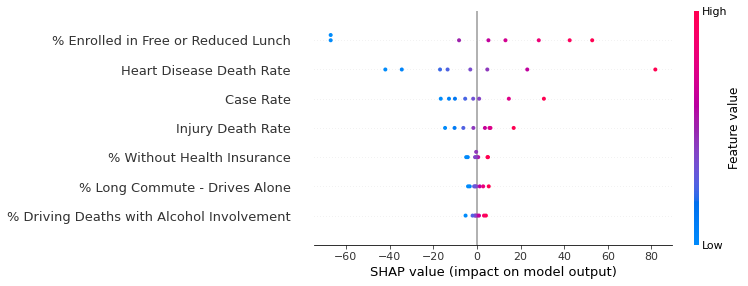

In [85]:
shap.summary_plot(shap_values, x_co2, feature_names=X_train_co2.columns)

## MLP: XGBoost Most Important Features - '% Diagnosed Diabetes' + 'COPD Mortality Rate'

In [106]:
X_train_co3 = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'COPD Mortality Rate'])

X_val_co3 = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'COPD Mortality Rate'])

X_test_co3 = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                'COPD Mortality Rate'])

In [107]:
train_data_co3 = PrepareData(X_train_co3, y_train)
val_data_co3 = PrepareData(X_val_co3, y_val)
test_data_co3 = PrepareData(X_test_co3, y_test)

In [108]:
train_loader_co3 = DataLoader(train_data_co3, 
                          batch_size)

valid_loader_co3 = DataLoader(val_data_co3, 
                          batch_size)

test_loader_co3 = DataLoader(test_data_co3, 
                         batch_size)

In [118]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [119]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_co3:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_co3:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_co3.model')

Epoch: 1 	Training Loss: 522.245305 	Validation Loss: 536.534510
Epoch: 2 	Training Loss: 494.377036 	Validation Loss: 487.169237
Epoch: 3 	Training Loss: 435.424878 	Validation Loss: 380.041303
Epoch: 4 	Training Loss: 353.683266 	Validation Loss: 267.431674
Epoch: 5 	Training Loss: 333.766215 	Validation Loss: 256.625723
Epoch: 6 	Training Loss: 337.596878 	Validation Loss: 254.342857
Epoch: 7 	Training Loss: 327.513945 	Validation Loss: 259.901226
Epoch: 8 	Training Loss: 316.338549 	Validation Loss: 257.425858
Epoch: 9 	Training Loss: 322.830427 	Validation Loss: 253.305303
Epoch: 10 	Training Loss: 308.317428 	Validation Loss: 250.900221
Epoch: 11 	Training Loss: 307.292619 	Validation Loss: 253.644329
Epoch: 12 	Training Loss: 314.294143 	Validation Loss: 260.089057
Epoch: 13 	Training Loss: 285.520291 	Validation Loss: 248.191929
Epoch: 14 	Training Loss: 299.705320 	Validation Loss: 245.029047
Epoch: 15 	Training Loss: 298.744295 	Validation Loss: 259.410158
Epoch: 16 	Training

In [120]:
best_val_loss

169.0576698996804

In [121]:
mlp.load_state_dict(torch.load('mlp_co3.model'))

In [122]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_co3:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_co3)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 185.893456



### Explain output through SHAP

In [123]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_co3.model'))

In [124]:
x_co3, _ = next(iter(train_loader_co3))

In [125]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_co3)

shap_values = explainer_shap.shap_values(X=x_co3,
                                      ranked_outputs=True)

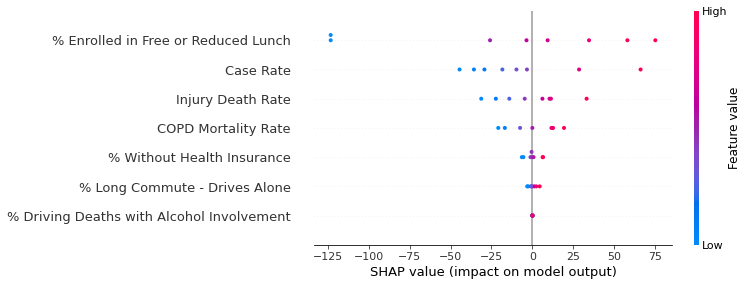

In [126]:
shap.summary_plot(shap_values, x_co3, feature_names=X_train_co3.columns)

## MLP: XGBoost Most Important Features - '% Diagnosed Diabetes' + '%  Adults with Obesity'

In [190]:
X_train_co4 = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '%  Adults with Obesity'])

X_val_co4 = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '%  Adults with Obesity'])

X_test_co4 = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '%  Adults with Obesity'])

In [128]:
train_data_co4 = PrepareData(X_train_co4, y_train)
val_data_co4 = PrepareData(X_val_co4, y_val)
test_data_co4 = PrepareData(X_test_co4, y_test)

In [129]:
train_loader_co4 = DataLoader(train_data_co4, 
                          batch_size)

valid_loader_co4 = DataLoader(val_data_co4, 
                          batch_size)

test_loader_co4 = DataLoader(test_data_co4, 
                         batch_size)

In [177]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [178]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_co4:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_co4:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_co4.model')

Epoch: 1 	Training Loss: 525.721927 	Validation Loss: 548.808791
Epoch: 2 	Training Loss: 523.904738 	Validation Loss: 548.769565
Epoch: 3 	Training Loss: 455.826358 	Validation Loss: 342.210216
Epoch: 4 	Training Loss: 304.579913 	Validation Loss: 258.458133
Epoch: 5 	Training Loss: 294.989392 	Validation Loss: 249.595433
Epoch: 6 	Training Loss: 300.476823 	Validation Loss: 264.078570
Epoch: 7 	Training Loss: 290.797260 	Validation Loss: 253.468776
Epoch: 8 	Training Loss: 285.816384 	Validation Loss: 254.235234
Epoch: 9 	Training Loss: 295.194529 	Validation Loss: 258.715742
Epoch: 10 	Training Loss: 279.674947 	Validation Loss: 250.372755
Epoch: 11 	Training Loss: 290.208971 	Validation Loss: 256.728302
Epoch: 12 	Training Loss: 285.670843 	Validation Loss: 253.922571
Epoch: 13 	Training Loss: 284.183667 	Validation Loss: 250.689565
Epoch: 14 	Training Loss: 289.124521 	Validation Loss: 251.727558
Epoch: 15 	Training Loss: 282.273801 	Validation Loss: 258.004741
Epoch: 16 	Training

In [179]:
best_val_loss

189.69549837979403

In [180]:
mlp.load_state_dict(torch.load('mlp_co4.model'))

In [181]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_co4:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_co4)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 197.918677



### Explain output through SHAP

In [183]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_co4.model'))

In [184]:
x_co4, _ = next(iter(train_loader_co4))

In [187]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_co4)

shap_values = explainer_shap.shap_values(X=x_co4,
                                      ranked_outputs=True)

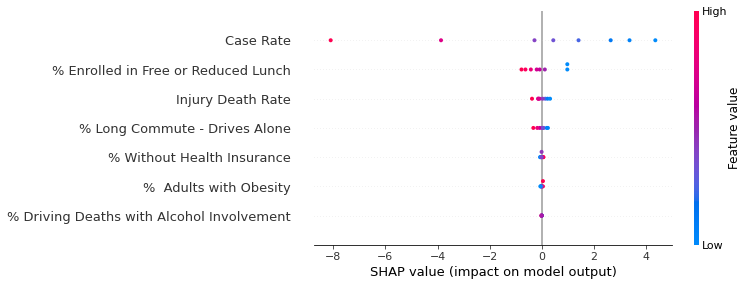

In [188]:
shap.summary_plot(shap_values, x_co4, feature_names=X_train_co4.columns)

## MLP: XGBoost Most Important Features

In [88]:
X_train_x = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '% Diagnosed Diabetes'])

X_val_x = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '% Diagnosed Diabetes'])

X_test_x = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate',
                '% Diagnosed Diabetes'])

In [89]:
train_data_x = PrepareData(X_train_x, y_train)
val_data_x = PrepareData(X_val_x, y_val)
test_data_x = PrepareData(X_test_x, y_test)

In [90]:
train_loader_x = DataLoader(train_data_x, 
                          batch_size)

valid_loader_x = DataLoader(val_data_x, 
                          batch_size)

test_loader_x = DataLoader(test_data_x, 
                         batch_size)

In [97]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [98]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_x:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_x:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_x_co.model')

Epoch: 1 	Training Loss: 474.942948 	Validation Loss: 465.730865
Epoch: 2 	Training Loss: 413.925426 	Validation Loss: 369.689933
Epoch: 3 	Training Loss: 334.064233 	Validation Loss: 268.160307
Epoch: 4 	Training Loss: 314.885032 	Validation Loss: 253.803553
Epoch: 5 	Training Loss: 301.555841 	Validation Loss: 257.884537
Epoch: 6 	Training Loss: 292.382291 	Validation Loss: 254.444455
Epoch: 7 	Training Loss: 303.730812 	Validation Loss: 254.568240
Epoch: 8 	Training Loss: 293.428870 	Validation Loss: 253.639740
Epoch: 9 	Training Loss: 300.102201 	Validation Loss: 258.050672
Epoch: 10 	Training Loss: 293.033144 	Validation Loss: 255.983909
Epoch: 11 	Training Loss: 294.728899 	Validation Loss: 263.313883
Epoch: 12 	Training Loss: 295.505755 	Validation Loss: 262.167874
Epoch: 13 	Training Loss: 283.992584 	Validation Loss: 255.163639
Epoch: 14 	Training Loss: 282.394736 	Validation Loss: 259.703717
Epoch: 15 	Training Loss: 283.395461 	Validation Loss: 260.398399
Epoch: 16 	Training

In [99]:
best_val_loss

170.41231606223366

In [100]:
mlp.load_state_dict(torch.load('mlp_x_co.model'))

In [101]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_x:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_x)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 183.705600



### Explain output through SHAP

In [102]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_x_co.model'))

In [103]:
x_x, _ = next(iter(train_loader_x))

In [104]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_x)

shap_values = explainer_shap.shap_values(X=x_x,
                                      ranked_outputs=True)

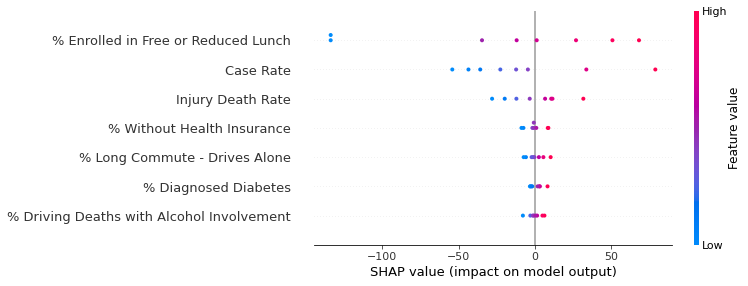

In [105]:
shap.summary_plot(shap_values, x_x, feature_names=X_train_x.columns)

## MLP: XGBoost Most Important Features - '% Diagnosed Diabetes'

In [189]:
X_train_noco = X_train.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate'])

X_val_noco = X_val.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate'])

X_test_noco = X_test.filter(['Case Rate', '% Without Health Insurance',
                '% Enrolled in Free or Reduced Lunch', '% Driving Deaths with Alcohol Involvement',
                '% Long Commute - Drives Alone', 'Injury Death Rate'])

In [191]:
train_data_noco = PrepareData(X_train_noco, y_train)
val_data_noco = PrepareData(X_val_noco, y_val)
test_data_noco = PrepareData(X_test_noco, y_test)

In [192]:
train_loader_noco = DataLoader(train_data_noco, 
                          batch_size)

valid_loader_noco = DataLoader(val_data_noco, 
                          batch_size)

test_loader_noco = DataLoader(test_data_noco, 
                         batch_size)

In [200]:
mlp = MLP(input_dim=6)
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [201]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(100):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_noco:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_noco:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_noco.model')

Epoch: 1 	Training Loss: 380.572149 	Validation Loss: 276.795796
Epoch: 2 	Training Loss: 316.164756 	Validation Loss: 251.403409
Epoch: 3 	Training Loss: 313.618079 	Validation Loss: 254.157322
Epoch: 4 	Training Loss: 310.302356 	Validation Loss: 254.713983
Epoch: 5 	Training Loss: 308.146801 	Validation Loss: 252.684368
Epoch: 6 	Training Loss: 297.446563 	Validation Loss: 251.539032
Epoch: 7 	Training Loss: 304.298000 	Validation Loss: 254.811072
Epoch: 8 	Training Loss: 297.783934 	Validation Loss: 259.475243
Epoch: 9 	Training Loss: 288.948115 	Validation Loss: 255.497197
Epoch: 10 	Training Loss: 296.572923 	Validation Loss: 260.454369
Epoch: 11 	Training Loss: 278.603519 	Validation Loss: 257.461494
Epoch: 12 	Training Loss: 282.835067 	Validation Loss: 258.249372
Epoch: 13 	Training Loss: 282.775099 	Validation Loss: 258.165982
Epoch: 14 	Training Loss: 288.991006 	Validation Loss: 262.247034
Epoch: 15 	Training Loss: 278.434950 	Validation Loss: 258.840986
Epoch: 16 	Training

In [202]:
best_val_loss

180.6399820501154

In [203]:
mlp.load_state_dict(torch.load('mlp_noco.model'))

In [204]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_noco:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_noco)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 192.299045



### Explain output through SHAP

In [206]:
mlp = MLP(input_dim=6)
mlp.load_state_dict(torch.load('mlp_noco.model'))

In [207]:
x_noco, _ = next(iter(train_loader_noco))

In [208]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_noco)

shap_values = explainer_shap.shap_values(X=x_noco,
                                      ranked_outputs=True)

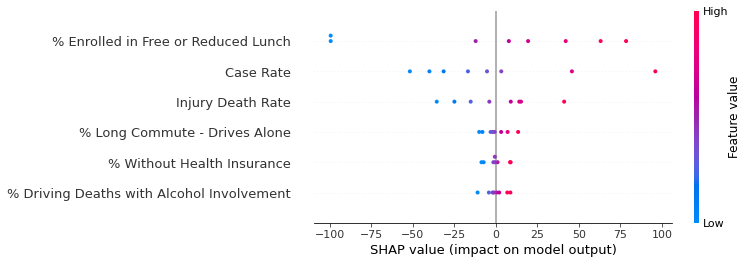

In [209]:
shap.summary_plot(shap_values, x_noco, feature_names=X_train_noco.columns)